In [1]:
import math
import numpy as np
# Scipy
from scipy.stats import boxcox
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Statsmodel
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Mute the warnings
import warnings as w
w.filterwarnings('always')
w.filterwarnings('ignore',category=DeprecationWarning)

## Importing the data set

In [2]:
series = pd.read_csv('yearly_water_usage.csv',sep=',',
                 header = 0, 
                 index_col = 0, 
                 parse_dates = True, 
                 squeeze = True)

##### Converting to a data frame

In [3]:
df = pd.DataFrame(series)
print(f'The shape of the data set is : {df.shape}')
df.head()

The shape of the data set is : (79, 1)


,Water
Year,
1885-01-01,356
1886-01-01,386
1887-01-01,397
1888-01-01,397
1889-01-01,413


### Developing Test Harness
#### Defining the Validation set
Here we take 15 data points in the end as our validation set and would train the model on the rest of the observations.

In [4]:
split = len(series)-15

##Validation set
train,validation = df[:split],df[split:]

##Shape of both the data frames
print('Shape of the Training set : %d || Shape of the Validation set : %d' % (train.shape[0],validation.shape[0]))

Shape of the Training set : 64 || Shape of the Validation set : 15


## Candidate models : walk-forward validation 
#### Persistence Model With Walk Forward Validation (Baseline RMSE)

Firstly, we can split the dataset into train and test sets directly. Converting loaded dataset to `float32` in case the loaded data still has some `String or Integer data types.`

In [5]:
x = train.values
x = x.astype('float32')
train_size = int(len(x)*0.50)

## Defining the training and the testing sets from the train data formulated earlier
train_data, test_data = x[:train_size] , x[train_size:]

#### Function of persistence model

`Before modelling, the intent is to establish a baseline of performance. This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared.`

>> #### The baseline prediction for time series forecasting is called the naive forecast, or persistence modelling. In this type of modelling, the observation at the previous time stamp is used as the prediction for the observation at the current time stamp. 

In [6]:
def persistence_model(train,test):
    old = [x for x in train]
    predictions = list()
    
    """
    For each step in the test dataset:
        A model will be trained.
        A one-step prediction will be made and the prediction will be evaluated.
        The actual observation from the test dataset will be added to the training dataset for the next iteration.
    """
    
    for i in range(len(test)):
        
        ##Predictions
        y_pred = old[-1]
        predictions.append(y_pred)

        #Observations
        old.append(test[i])
        
        print('Predicted : %.3f ||| Expected/Actual : %.3f' % (y_pred,test[i]))
    print('-'*100)   
    print('\t\t\t\t', 'Baseline RMSE : %.2f' % (math.sqrt(mean_squared_error(test, predictions))))
    
# Persistence model
persistence_model(train_data, test_data)

Predicted : 515.000 ||| Expected/Actual : 526.000
Predicted : 526.000 ||| Expected/Actual : 503.000
Predicted : 503.000 ||| Expected/Actual : 503.000
Predicted : 503.000 ||| Expected/Actual : 503.000
Predicted : 503.000 ||| Expected/Actual : 515.000
Predicted : 515.000 ||| Expected/Actual : 522.000
Predicted : 522.000 ||| Expected/Actual : 492.000
Predicted : 492.000 ||| Expected/Actual : 503.000
Predicted : 503.000 ||| Expected/Actual : 503.000
Predicted : 503.000 ||| Expected/Actual : 450.000
Predicted : 450.000 ||| Expected/Actual : 432.000
Predicted : 432.000 ||| Expected/Actual : 432.000
Predicted : 432.000 ||| Expected/Actual : 458.000
Predicted : 458.000 ||| Expected/Actual : 462.000
Predicted : 462.000 ||| Expected/Actual : 503.000
Predicted : 503.000 ||| Expected/Actual : 488.000
Predicted : 488.000 ||| Expected/Actual : 466.000
Predicted : 466.000 ||| Expected/Actual : 492.000
Predicted : 492.000 ||| Expected/Actual : 503.000
Predicted : 503.000 ||| Expected/Actual : 515.000


>> ### Above we print the the prediction and the observation for each of the data points in the test data set. A baseline RMSE of 22.59 would mean that on an average, the model was wrong by about 22.5 liters per capita per day for each prediction made.

## Exploratory Data Analysis

### Summary Statistics

In [7]:
df.describe()

,Water
count,79.000000
mean,512.025316
std,75.685072
min,344.000000
25%,462.000000
50%,503.000000
75%,581.000000
max,662.000000


###### Conclusions :-

* The standard deviation is tightly placed with mean meaning that the data is nearly normall or a little right skewed(also implied by the fact that mean is a little more than the median)

#### Line plot

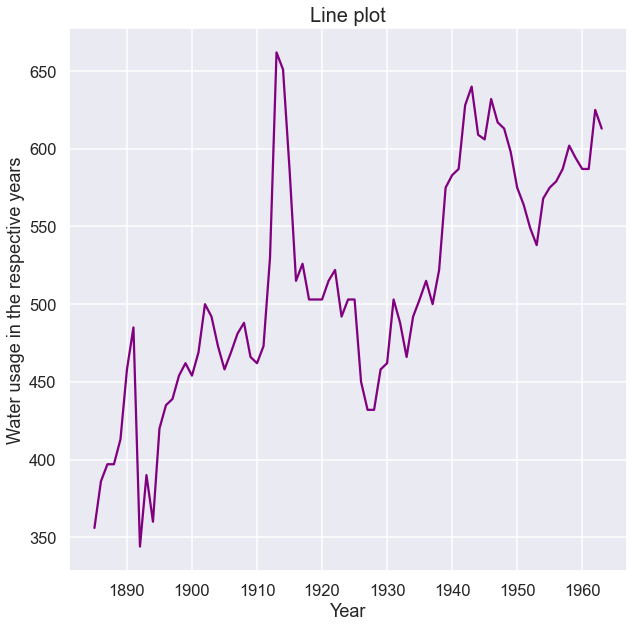

In [8]:
sns.set_theme()
sns.set_context('talk')
plt.figure(figsize=(10,10))
plt.plot(df,color='purple')
plt.xlabel('Year')
plt.ylabel('Water usage in the respective years')
plt.title('Line plot',fontdict={'fontsize':20})
plt.show()

###### Conclusions :-

* There are some fluctuations in the line plot and there seems to be an upward trend overall.
* There seems to be a huge increase in the water consumption between 1910 to 1095 & yet again between 1940 to 1955. This could be due to increase in the population in Baltimore.

### Density plot

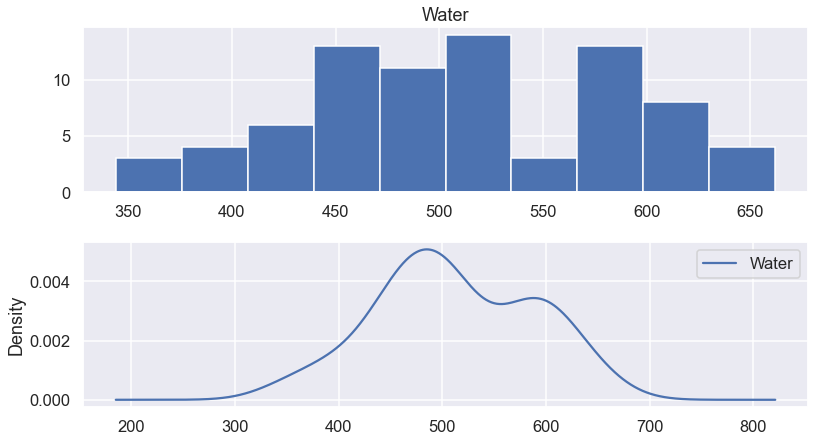

In [9]:
sns.set_theme()
sns.set_context('talk')
plt.figure(figsize=(13,7))
plt.subplot(211)
df.hist(ax=plt.gca())
plt.subplot(212)
df.plot(kind='kde', ax=plt.gca())
plt.show()

###### Conclusions :-
* The first plot suggests that the data is nearly normal but not perfectly normal as derived through the summary statistics above.
* The second plot suggests that the data is exponentially distributed and will require power transformation.

### Box & Whisker Plot

Here we divide the data set into groups of 5 years in order to be able to visualize it well.

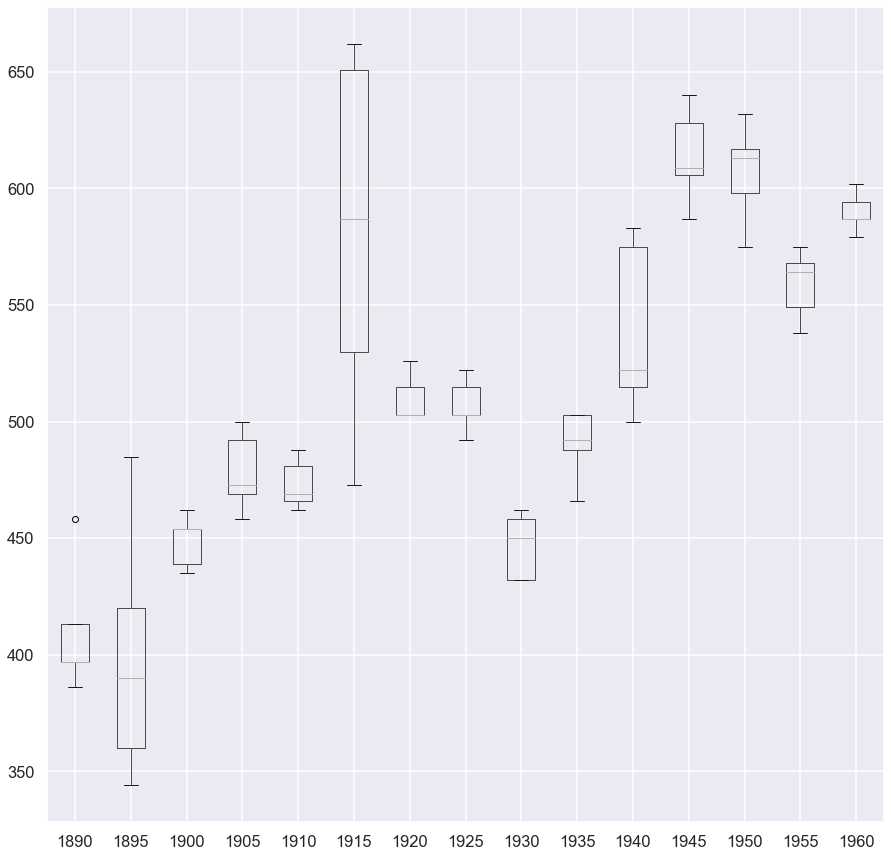

In [10]:
# Boxplots for each half a decade

## Grouping by 5 years
sns.set_theme()
sns.set_context('talk')
groups = series['1885':'1960'].groupby(pd.Grouper(freq='5Y'))
decades = pd.DataFrame()
plt.figure(figsize=(15,15))

for name, group in groups:
    if len(group.values) == 5:
        decades[name.year] = group.values

decades.boxplot()
plt.show()

###### Conclusions :-

* There are no outliers except in 1890
* There is a lot of dispersion between 1910 & 1920 and 1935 & 1945.

### Heatmap

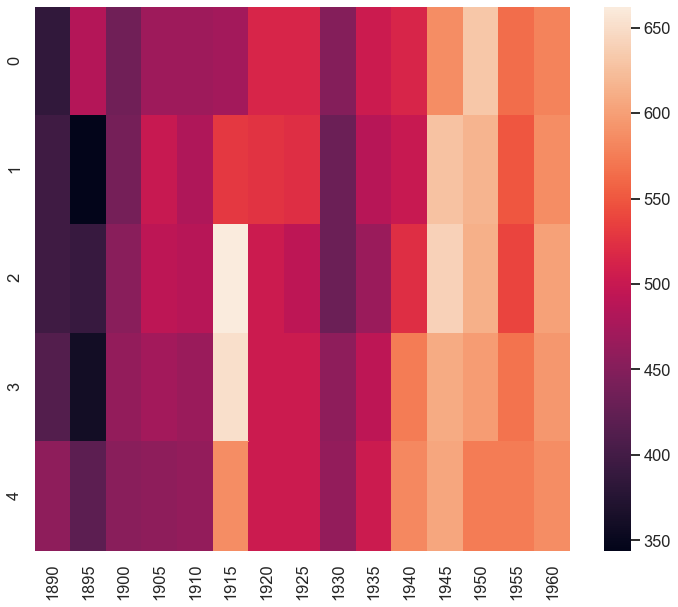

In [11]:
sns.set_theme()
sns.set_context('talk')
plt.figure(figsize=(12,10))
sns.heatmap(decades)
plt.show()

### Test of Stationarity
#### Augmented Dickey-Fuller test.

#### `Analysis of the time series data assumes that we are working with a stationary time series. The time series is likely non-stationary. We can make it stationary by first differencing the series and using a statistical test to confirm that the result is stationary.`

In [12]:
## We check if the series is staionary
adf = adfuller(np.concatenate(train.values.astype('float64')))
print(f'The test statistic is : {adf[0]}')
print('The p-value is : %.2f' % adf[1])
print('\n')
print('The critical values : ', adf[4])

The test statistic is : -1.8522170939124376
The p-value is : 0.35


The critical values :  {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}


>> ##### Considering our level of significance as 5%, the critical value is -2.91 whihc is less than the test statistic obtained. Hence, we fail to reject the null hyothesis and conclude that the series does not have a unit root - hence the time serfies is non-stationary.

>> ##### Since the ARIMA model assumes a stationary series, hence we try to make it stationary by de trending the time series. Note that none of the other components of time series were present prominently. 

In [13]:
adf_data = train.values
adf_diff = adfuller(np.concatenate([adf_data[i] - adf_data[i-1] for i in range(1,len(adf_data))]))

In [14]:
print(f'The test statistic is : {adf_diff[0]}')
print('The p-value is : %.10f' % adf_diff[1])
print('\n')
print('The critical values : ', adf_diff[4])

The test statistic is : -6.056828765834675
The p-value is : 0.0000001239


The critical values :  {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}


>> #### Hence, since the test statistic is less than the critical value at 5 % level of significance, hence we reject the hypothesis and conclude the the series is stationary.

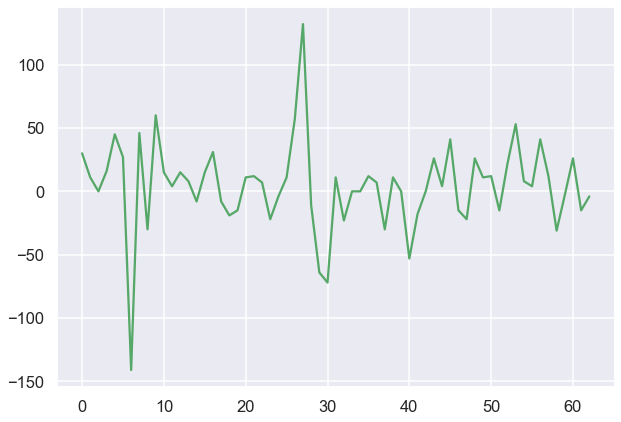

In [15]:
## The stationarity of the time series can also be seen through the plot given below
z = np.concatenate([adf_data[i] - adf_data[i-1] for i in range(1,len(adf_data))])
sns.set_theme()
sns.set_context('talk')
plt.figure(figsize=(10,7))
plt.plot(z,color='g')
plt.show()

###### We see that the series has de trended and hence it could be deemed as stationary.

##### Now we find the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively. This is done by  reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots

### ACF and PACF plot

#### The ACF is used to check how strong the relationship is between a value and its values in previous time steps. The ACF plot shows the relationship between the a value and its values from the previous time-steps. The region highlighted in blue colour in the plot denotes the 95% confidence intervals. If any bar lies outside of this region then it means that that lagged value is significant. 

#### This PACF plot summarizes the relationship between a value and its previous value with any correlations removed. The blue region holds the same meaning in this plot as well.

c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


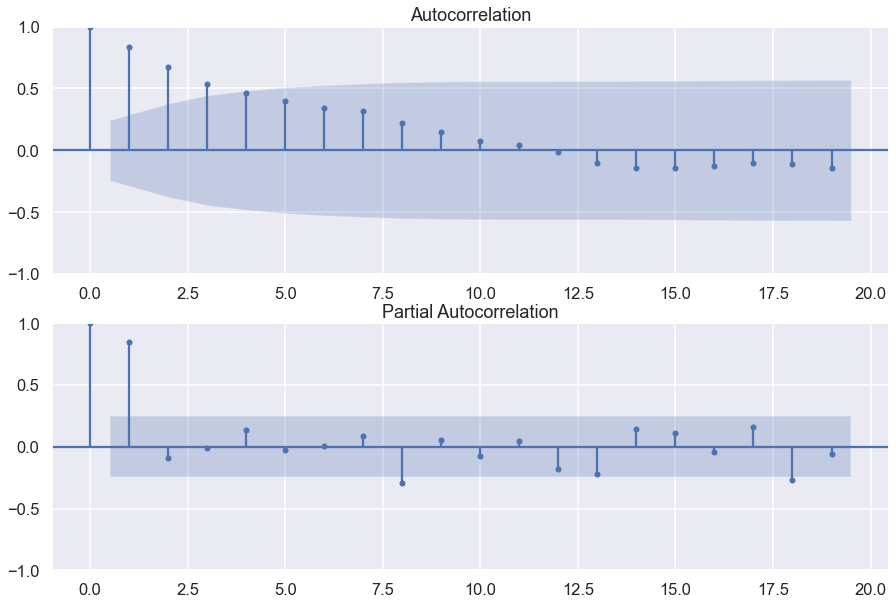

In [16]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plot_acf(train, ax=plt.gca())
plt.subplot(212)
plot_pacf(train, ax=plt.gca())
plt.show()

## Analysis (ACF And PACF):

### Following observations can be made from above plots :

#### 1- From ACF plot it can be observed that lag uptill 3 shows great correlation so will consider value of p=3 hence its an AR() process.
#### 2- From PACF plot it can be observed that lag values uptill 1 so will consider value of q=1 hence its an MA(1) process.
#### 3- Since, from the previous differencing part we found that d=1 makes the time series stationary, hence will take value of d=1.

# Modelling with ARIMA (AutoRegressive Integrated Moving Average)
### The main parameters in ARIMA are p, d, q. The p is the number of lag observations. The d is the number of times that the data is differenced. The q is the size of the moving average window.

In [17]:
# ## Predicting using the walk-forward method
# history = [x for x in train_data]
# predictions = []

# ## Looping through the number of predictions to make
# for i in range(len(test_data)):
#     ### Fitting the ARIMA model
#     model = ARIMA(history, order=(2,1,1))
#     model_fit = model.fit()

#     ### Predicting using the fitted ARIMA model
#     yhat = model_fit.forecast()[0]
#     predictions.append(yhat)

#     ### Adding the next value into history (walk-forward implementation)
#     obs = test_data[i]
#     history.append(obs)
#     print(f'>Predicted: {yhat}, Expected: {obs}')

# ## Calculatinf the RMSE
# rmse = np.sqrt(mean_squared_error(test_data, predictions))
# print(f"RMSE: {rmse:.3f}")

In [35]:
def arima_model(train, test, order):
    
    # Predicting using the walk-forward method
    old = [i for i in train]
    predictions = []
    
    ## Looping through the number of predictions to make
    for i in range(len(test)):
        
        # get predictions
        fitted_model = ARIMA(old, order=order).fit()
        y_pred = fitted_model.forecast()[0]
        predictions.append(y_pred)
        
        # Adding the next value into history (walk-forward implementation)
        old.append(test[i])
        
        print('Predicted: %.3f Actual: %.3f' % (y_pred, test[i]))
    
    #Calculate the RMSE
    print('-'*100)   
    print('\n\t\t\tRMSE: %.2f with ARIMA%s' % (math.sqrt(mean_squared_error(test, predictions)), order))
    
    # RESIDUAL ANALYSIS
    print('\n\n-----------------------------------------------RESIDUAL ANALYSIS-----------------------------------------------')
    rsd = pd.DataFrame([test[i] - predictions[i] for i in range(len(test))])
    
    # plot residuals
    print(rsd.describe())
    plt.figure(figsize=(20,15))
    plt.subplot(511)
    rsd.hist(ax=plt.gca())
    plt.title('Histogram')
    plt.subplot(512)
    rsd.plot(kind='kde', ax=plt.gca())
    plt.title('Density Plot')
    plt.subplot(513)
    rsd.plot(kind='line', ax=plt.gca())
    plt.title('Line plot')
    plt.subplot(514)
    plot_acf(rsd, ax=plt.gca())
    plt.tight_layout()
    plt.show()

Predicted: 507.358 Actual: 526.000
Predicted: 558.046 Actual: 503.000
Predicted: 533.837 Actual: 503.000
Predicted: 518.297 Actual: 503.000
Predicted: 517.903 Actual: 515.000
Predicted: 523.588 Actual: 522.000
Predicted: 525.897 Actual: 492.000
Predicted: 492.733 Actual: 503.000
Predicted: 503.848 Actual: 503.000
Predicted: 509.473 Actual: 450.000
Predicted: 455.885 Actual: 432.000
Predicted: 441.250 Actual: 432.000
Predicted: 450.327 Actual: 458.000
Predicted: 471.067 Actual: 462.000
Predicted: 466.145 Actual: 503.000
Predicted: 497.829 Actual: 488.000
Predicted: 481.151 Actual: 466.000
Predicted: 455.251 Actual: 492.000
Predicted: 489.148 Actual: 503.000
Predicted: 502.193 Actual: 515.000
Predicted: 507.442 Actual: 500.000
Predicted: 492.910 Actual: 522.000
Predicted: 515.253 Actual: 575.000
Predicted: 570.407 Actual: 583.000
Predicted: 570.526 Actual: 587.000
Predicted: 569.356 Actual: 628.000
Predicted: 620.609 Actual: 640.000
Predicted: 635.231 Actual: 609.000
Predicted: 597.133 A

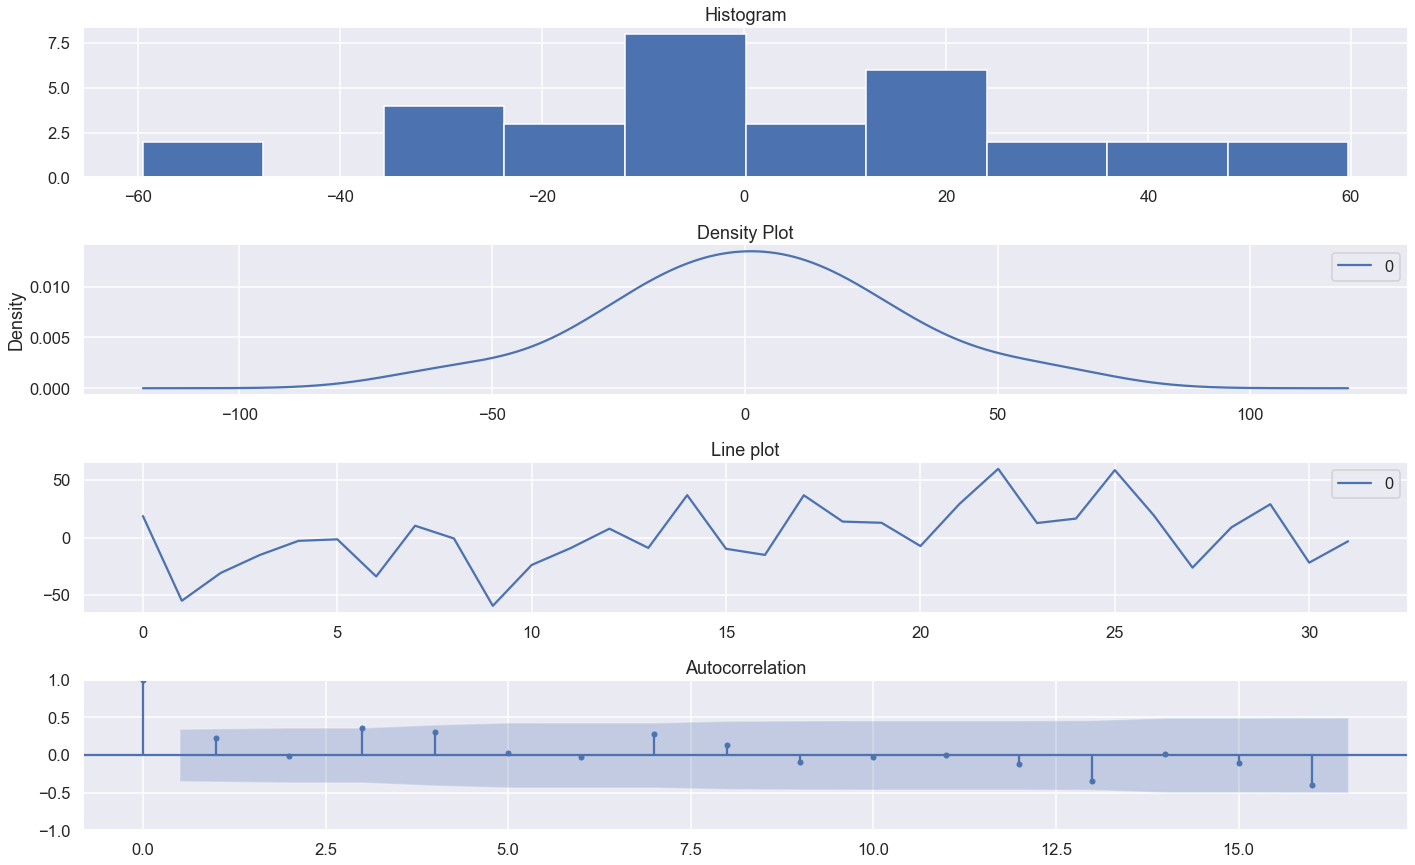

In [19]:
arima_model(train_data,test_data,(3,1,1))

>> ##### According to the ACF & PACF plots, we observe that we cannot surpass the performance of the persistence model. To confirm this analysis, we can grid search a suite of ARIMA hyperparameters and check that no models result in better out of sample RMSE performance. We search values of p, d, and q for combinations (skipping those that fail to converge), and find the combination that results in the best performance. 

Following observation can be made from the above ARIMA(3,1,1)
* ACF shows that majority of the correlation is captured by the model.
* Observing histogram and density plots suggest applying power transform on the data to better expose the signal by removing the noise, before modelling ARIMA on the data.

## ARIMA GRID search 

In [34]:

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def check_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values:np.array, d_values:np.array, q_values:np.array):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = check_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


# evaluate parameters
p_values = np.arange(0, 8)
d_values = np.arange(0, 3)
q_values = np.arange(0, 8)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=76.383
ARIMA(0, 0, 1) RMSE=48.567
ARIMA(0, 0, 2) RMSE=37.259
ARIMA(0, 0, 3) RMSE=34.850
ARIMA(0, 0, 4) RMSE=31.867
ARIMA(0, 0, 5) RMSE=32.233
ARIMA(0, 0, 6) RMSE=31.733
ARIMA(0, 0, 7) RMSE=34.574
ARIMA(0, 1, 0) RMSE=22.590
ARIMA(0, 1, 1) RMSE=22.645
ARIMA(0, 1, 2) RMSE=23.391
ARIMA(0, 1, 3) RMSE=25.637
ARIMA(0, 1, 4) RMSE=31.690
ARIMA(0, 1, 5) RMSE=28.502
ARIMA(0, 1, 6) RMSE=30.297
ARIMA(0, 1, 7) RMSE=35.841
ARIMA(0, 2, 0) RMSE=34.051
ARIMA(0, 2, 1) RMSE=22.675
ARIMA(0, 2, 2) RMSE=22.731
ARIMA(0, 2, 3) RMSE=23.946
ARIMA(0, 2, 4) RMSE=29.413
ARIMA(0, 2, 5) RMSE=29.840
ARIMA(0, 2, 6) RMSE=34.114
ARIMA(0, 2, 7) RMSE=34.097
ARIMA(1, 0, 0) RMSE=25.260
ARIMA(1, 0, 1) RMSE=25.686
ARIMA(1, 0, 2) RMSE=27.860
ARIMA(1, 0, 3) RMSE=26.462
ARIMA(1, 0, 4) RMSE=26.958
ARIMA(1, 0, 5) RMSE=28.630
ARIMA(1, 0, 6) RMSE=29.852
ARIMA(1, 0, 7) RMSE=33.422
ARIMA(1, 1, 0) RMSE=22.642
ARIMA(1, 1, 1) RMSE=22.614
ARIMA(1, 1, 2) RMSE=24.244
ARIMA(1, 1, 3) RMSE=25.786
ARIMA(1, 1, 4) RMSE=28.727
A

### Hence we use the model with the parameters ARIMA(2,1,0) and review the residuals.

Predicted: 519.213 Actual: 526.000
Predicted: 534.414 Actual: 503.000
Predicted: 501.627 Actual: 503.000
Predicted: 504.810 Actual: 503.000
Predicted: 503.000 Actual: 515.000
Predicted: 515.258 Actual: 522.000
Predicted: 521.218 Actual: 492.000
Predicted: 490.822 Actual: 503.000
Predicted: 505.630 Actual: 503.000
Predicted: 502.105 Actual: 450.000
Predicted: 449.266 Actual: 432.000
Predicted: 436.278 Actual: 432.000
Predicted: 433.563 Actual: 458.000
Predicted: 458.735 Actual: 462.000
Predicted: 459.695 Actual: 503.000
Predicted: 503.985 Actual: 488.000
Predicted: 484.454 Actual: 466.000
Predicted: 466.747 Actual: 492.000
Predicted: 494.555 Actual: 503.000
Predicted: 500.737 Actual: 515.000
Predicted: 514.282 Actual: 500.000
Predicted: 498.551 Actual: 522.000
Predicted: 523.719 Actual: 575.000
Predicted: 574.507 Actual: 583.000
Predicted: 578.115 Actual: 587.000
Predicted: 586.419 Actual: 628.000
Predicted: 629.324 Actual: 640.000
Predicted: 636.971 Actual: 609.000
Predicted: 606.455 A

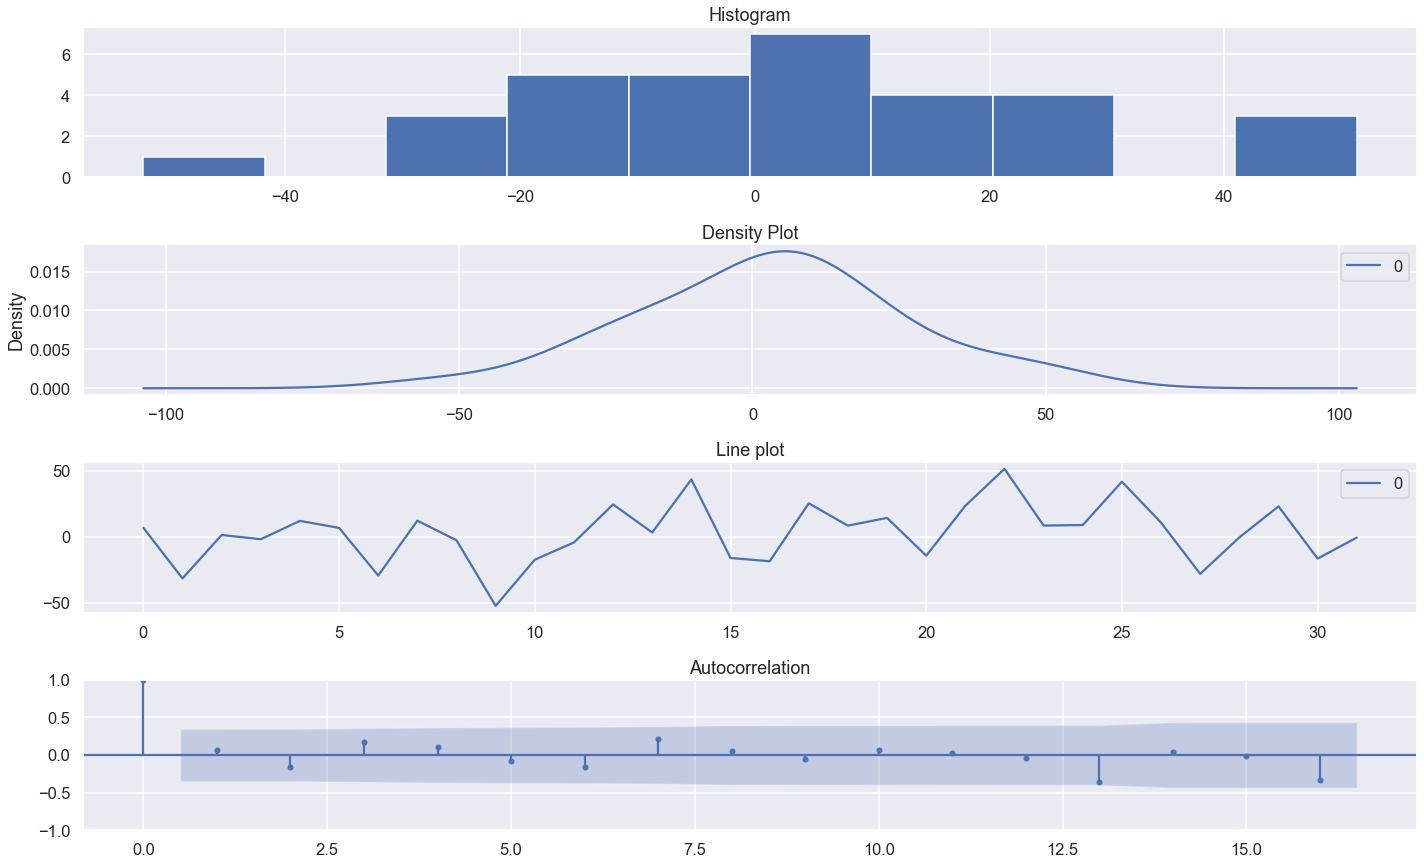

In [36]:
arima_model(train_data,test_data,(2,1,0))

#### The distribution of the residuals is plotted and it looks nearly normal or Gaussian

# Model Validation

In [38]:
# save finalized model to file
model = ARIMA(train.values, order=(2,1,0))
model_fit = model.fit()

# save model
model_fit.save('model.pkl')

* ### model.pkl This is the ARIMAResult object from the call to ARIMA.fit(). This includes the coefficients and all other internal data returned when fitting the model.

>Predicted=614.503, Expected=598.000
>Predicted=597.860, Expected=575.000
>Predicted=575.625, Expected=564.000
>Predicted=565.899, Expected=549.000
>Predicted=549.384, Expected=538.000
>Predicted=538.929, Expected=568.000
>Predicted=570.511, Expected=575.000
>Predicted=572.210, Expected=579.000
>Predicted=578.480, Expected=587.000
>Predicted=586.983, Expected=602.000
>Predicted=601.943, Expected=594.000
>Predicted=592.096, Expected=587.000
>Predicted=587.475, Expected=587.000
>Predicted=587.715, Expected=625.000
>Predicted=626.865, Expected=613.000
RMSE: 16.786


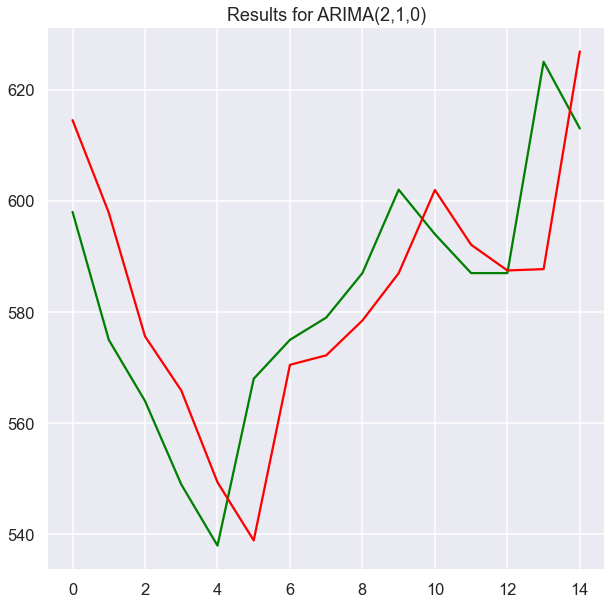

In [46]:
X = train.values.astype('float32')
history = [x for x in X]
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    yhat = float(model_fit.forecast()[0])
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
    
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
sns.set_theme()
sns.set_context('talk')
plt.figure(figsize=(10,10))
plt.plot(y,label='True',color='green')
plt.plot(predictions, label='Predicted',color='red')
plt.title('Results for ARIMA(2,1,0)')
plt.savefig(fname='Results.jpg', dpi=300)
plt.show()

* ### Hence we observe that we have a very low RMSE on the validation set of 16.786 which means that our model is working fine on the "unseen" data set.

* ### Secondly, It can be observed that majority of the autocorrelation in captured by the model with the parameters (2,1,0).